<a href="https://colab.research.google.com/github/ethvedbitdesjan/SummerResearch/blob/main/ComplexConvolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('content/')

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


In [2]:
%cd content/MyDrive/SummerResearch

/content/content/MyDrive/SummerResearch


In [3]:
# Critical imports
import os
import numpy as np
import pandas as pd
from PIL import Image
import random
import cv2
import copy
import torch
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler

In [4]:
funny_set = set()
not_funny_set = set()
with open('labelled_data/funny_combined1.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        funny_set.add(line.strip())
with open('labelled_data/not_funny_combined1.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        not_funny_set.add(line.strip())
train_data = []
train_funny_data = []
train_not_funny_data = []
count = 0
added = set()
for file in os.listdir('Funny_Originals_Final'):
  img_array = Image.open(os.path.join('Funny_Originals_Final', file))
  if file in funny_set:
    added.add(file)
    train_funny_data.append((img_array, 1))
  if file in not_funny_set:
    added.add(file)
    train_not_funny_data.append((img_array, 0))
  count += 1
for file in os.listdir('Non-Funny_Modified_Final'):
  img_array = Image.open(os.path.join('Non-Funny_Modified_Final', file))
  if file in funny_set:
    added.add(file)
    train_funny_data.append((img_array, 1))
  if file in not_funny_set:
    added.add(file)
    train_not_funny_data.append((img_array, 0))
random.seed(2354465)

In [5]:
print(len(train_funny_data), len(train_not_funny_data))
train_not_funny_data1 = random.sample(train_not_funny_data, k = len(train_funny_data)+10)
train_data = train_funny_data + train_not_funny_data1
len(train_data), len(train_funny_data), len(train_not_funny_data), len(train_not_funny_data1)
train_data = train_funny_data + train_not_funny_data

1133 1560


In [6]:
random.shuffle(train_data)

In [7]:
class FunnyNotFunnyDataset(Dataset):
    def __init__(self, data, root_dir=None, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image = self.data[index][0]
        if self.transform:
          image = self.transform(image)
        label = self.data[index][1]
        label_tensor = torch.zeros(1)
        if label == 1:
          label_tensor[0] = 1
        return {'image_data':image, 'label':label_tensor}

In [8]:
class ResNetAdded(torch.nn.Module):
    def __init__(self, resnet50=None, train_full=True):
        super(ResNetAdded, self).__init__()
        if resnet50:
            self.resnet50 = resnet50
        else:
            self.resnet50 = models.resnet50(pretrained=True)
        if not train_full:
            for param in self.resnet50.parameters():
                param.requires_grad = False
        self.resnet50.fc = torch.nn.Linear(2048, 1)
        self.feature_extractor = None

    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """

        # x = self.resnet50(x)
        # preds = self.classifier(x)
        preds = self.resnet50(x)
        return preds

    def feature_extraction(self, x):
        if self.feature_extractor is None:
            self.feature_extractor = torch.nn.Sequential(*(list(self.resnet50.children())[:-1]))
        features = self.feature_extractor(x)
        return features

class AlexNetAdded(torch.nn.Module):
    def __init__(self, alexnet=None, train_full=True):
        super(AlexNetAdded, self).__init__()
        if alexnet:
            self.alexnet = alexnet
        else:
            self.alexnet = models.alexnet(pretrained=True)
        if not train_full:
            for param in self.alexnet.parameters():
                param.requires_grad = False
        self.alexnet.classifier[6] = torch.nn.Linear(4096, 1)
        self.feature_extractor = None
    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """
        preds = self.alexnet(x)
        return preds

class InceptionAdded(torch.nn.Module):
    def __init__(self, inception=None, train_full=True):
        super(InceptionAdded, self).__init__()
        if inception:
            self.xception = inception
        else:
            self.inception = models.inception_v3(pretrained=True)
        if not train_full:
            for param in self.inception.parameters():
                param.requires_grad = False
        self.inception.fc = torch.nn.Linear(2048, 1)
        self.feature_extractor = None
    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """
        preds = self.inception(x)
        return preds

class DenseNetAdded(torch.nn.Module):
    def __init__(self, densenet=None, train_full=True):
        super(DenseNetAdded, self).__init__()
        if densenet:
            self.densenet = densenet
        else:
            self.densenet = models.densenet201(pretrained=True)
        if not train_full:
            for param in self.densenet.parameters():
                param.requires_grad = False
        self.densenet.classifier = torch.nn.Linear(1920, 1)
        self.feature_extractor = None
    def forward(self, x):
        """
        x: A batch of images.

        Returns: A tensor of predictions.
        """
        preds = self.densenet(x)
        return preds

In [9]:
model = ResNetAdded(train_full=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
idx_train_split = int(0.6 * len(train_data))
idx_test_split = int(0.8*len(train_data))
IMAGE_SIZE = 224
NUM_CLASSES = 1103
BATCH_SIZE = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize(IMG_MEAN, IMG_STD)
])
test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMG_MEAN, IMG_STD)
])
train_dataset = FunnyNotFunnyDataset(train_data[:idx_train_split], transform = train_transform)
valid_dataset = FunnyNotFunnyDataset(train_data[idx_train_split:idx_test_split], transform = test_transform)
test_dataset = FunnyNotFunnyDataset(train_data[idx_test_split:] ,transform = test_transform)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True)
model.to(device)

ResNetAdded(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [11]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)

In [12]:
import gc
gc.collect()

9

In [13]:
import matplotlib.pyplot as plt

In [14]:
def train(num_epochs, save_name):
  best_valid_loss = 10000
  best_valid_epoch = -1
  all_train_losses = []
  all_valid_losses = []

  for epoch in range(num_epochs):
    print('epoch:', epoch)
    model.train()
    running_loss = 0.0
    total_loss = []
    lrs = []
    total_size = 0
    correct = 0
    for i, data in enumerate(train_dataloader):
      inputs = data['image_data'].to(device)
      label = data['label'].to(device)
      inputs = inputs.type(torch.cuda.FloatTensor)
      label = label.type(torch.cuda.FloatTensor)
      output = model.forward(inputs)
      gc.collect()
      del inputs
      loss = criterion(output, label)
      loss.mean().backward()
      optimizer.step()
      optimizer.zero_grad()
      total_loss.append(loss.item())
      gc.collect()
      del loss
      torch.cuda.empty_cache()
      output = torch.sigmoid(output)
      predictions = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
      correct += (predictions == label).float().sum().item()
      gc.collect()
      #gpu_usage()
      del predictions
      del label
      del output
      #gpu_usage()
      torch.cuda.empty_cache()
      #print(predictions, "\n", targets, "\n", correct)
      total_size += BATCH_SIZE
      accuracy = correct/(total_size)
      #print(correct, total_size)
      lrs.append(optimizer.param_groups[0]['lr'])
    print('Mean Train loss:', np.mean(total_loss), 'Train Accuracy:', accuracy)
    all_train_losses.append(np.mean(total_loss))
    model.eval()
    total_size = 0
    total_loss = []
    correct = 0
    with torch.no_grad():
        for data in valid_dataloader:
            gc.collect()
            torch.cuda.empty_cache()
            inputs = data["image_data"].to(device)
            targets = data["label"].to(device)

            inputs = inputs.type(torch.cuda.FloatTensor)
            targets = targets.type(torch.cuda.FloatTensor)
            #print(ids.shape, "ids")
            batch_size = inputs.size(0)

            output = model.forward(inputs)
            gc.collect()
            del inputs
            loss = criterion(output, targets)
            total_loss.append(loss.item())
            gc.collect()
            del loss
            torch.cuda.empty_cache()
            output = torch.sigmoid(output)

            predictions = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
            if (predictions == targets).float().sum().item() > batch_size:
              print('error?')
            correct += (predictions == targets).float().sum().item()
            gc.collect()
            del predictions
            del targets
            del output
            torch.cuda.empty_cache()
            total_size += batch_size
            #gpu_usage()
        accuracy = correct/(total_size)
    all_valid_losses.append(np.mean(total_loss))
    if np.sum(total_loss) < best_valid_loss:
      best_valid_loss = np.sum(total_loss)
      best_model_weights = copy.deepcopy(model.state_dict())
      best_valid_epoch = epoch
      path = save_name
      torch.save(model.state_dict(), path)
      print(f"Model Saved")
    elif epoch - best_valid_epoch > 4:
      break
    print("Validation Loss over a batch: {:.4f}; Validation Accuracy: {:.2f}%".format(np.mean(total_loss), accuracy*100))
  epochs = [i+1 for i in range(len(all_train_losses))]
  plt.plot(epochs, all_train_losses, marker='o')
  plt.plot(epochs, all_valid_losses, marker='o')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

In [15]:
def test():
  model.eval()
  total_size = 0
  total_loss = []
  correct = 0
  all_preds = []
  all_targets = []
  with torch.no_grad():
      for data in test_dataloader:
          gc.collect()
          torch.cuda.empty_cache()
          inputs = data["image_data"].to(device)
          targets = data["label"].to(device)

          inputs = inputs.type(torch.cuda.FloatTensor)
          targets = targets.type(torch.cuda.FloatTensor)
          #print(ids.shape, "ids")
          batch_size = inputs.size(0)

          output = model.forward(inputs)
          gc.collect()
          del inputs
          loss = criterion(output, targets)
          total_loss.append(loss.item())
          gc.collect()
          del loss
          torch.cuda.empty_cache()
          output = torch.sigmoid(output)

          predictions = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
          if (predictions == targets).float().sum().item() > batch_size:
            print('error?')
          all_preds += predictions.flatten().cpu().detach().tolist()
          all_targets += targets.flatten().cpu().detach().tolist()
          correct += (predictions == targets).float().sum().item()
          gc.collect()
          del predictions
          del targets
          del output
          torch.cuda.empty_cache()
          total_size += batch_size
          #gpu_usage()
      accuracy = correct/(total_size)
  print("Total Test Loss: {:.4f}; Test Accuracy: {:.2f}%".format(np.sum(total_loss), accuracy*100))

epoch: 0
Mean Train loss: 0.6745421794971617 Train Accuracy: 0.5891089108910891
Model Saved
Validation Loss over a batch: 0.6604; Validation Accuracy: 59.37%
epoch: 1
Mean Train loss: 0.6475236634216687 Train Accuracy: 0.6188118811881188
Model Saved
Validation Loss over a batch: 0.6592; Validation Accuracy: 59.74%
epoch: 2
Mean Train loss: 0.630361005221263 Train Accuracy: 0.6472772277227723
Validation Loss over a batch: 0.6822; Validation Accuracy: 58.63%
epoch: 3
Mean Train loss: 0.6303107608662973 Train Accuracy: 0.6342821782178217
Model Saved
Validation Loss over a batch: 0.6547; Validation Accuracy: 60.85%
epoch: 4
Mean Train loss: 0.6278683342555962 Train Accuracy: 0.6330445544554455
Model Saved
Validation Loss over a batch: 0.6526; Validation Accuracy: 62.89%
epoch: 5
Mean Train loss: 0.6262671885514023 Train Accuracy: 0.6534653465346535
Validation Loss over a batch: 0.7241; Validation Accuracy: 57.88%
epoch: 6
Mean Train loss: 0.6399676100452347 Train Accuracy: 0.62871287128712

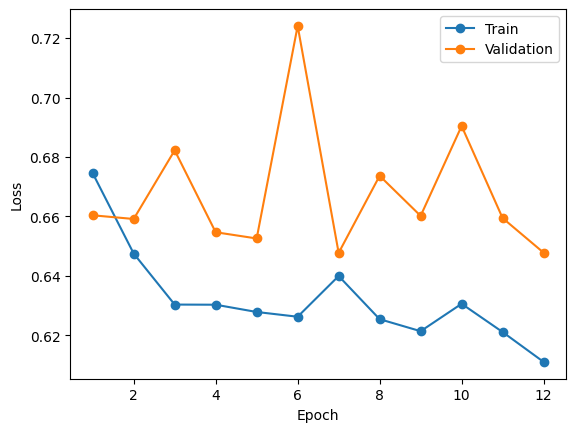

In [16]:
train(num_epochs=15, save_name="best_model_resnet_last_layer1.bin")

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load('best_model_resnet_last_layer1.bin'))
model.to(device)

ResNetAdded(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [18]:
test()

Total Test Loss: 21.5378; Test Accuracy: 64.56%
